# COGS 108 - Final Project

## Important

- ONE, and only one, member of your group should upload this notebook to TritonED. 
- Each member of the group will receive the same grade on this assignment. 
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that for cells in which you want graders to see output that these cells have been executed.

## Group Members: Fill in the Student IDs of each group member here

Replace the lines below to list each persons full student ID, ucsd email and full name.

- A91063209 (Zongchen) 
- A92060274 (Karen)
- A14443387 (Brandon) 
- U07313790 (Nareg)
- A12933386 (Justin)
- A13779898 (Sida Qin)


Start your project here.

## Introduction and Background


## Data Description

### The following sites will be scrapped for the aritist names
- Control dataset - notable/popular musicians who are alive and happy
    Billboard Hot 100 Artists
    https://en.wikipedia.org/wiki/List_of_Billboard_Hot_100_chart_achievements_by_decade 
- Dependent dataset - notable/popular musicians who have passed as a result of self-inflicted harm, mental health deterioration, and other issues 
    List of deaths of pop musicians by drug overdose
    https://en.wikipedia.org/wiki/List_of_pop_musicians_who_died_of_drug_overdose
- Musicians that have battled drug addiction
    https://drugabuse.com/30-famous-musicians-who-have-battled-drug-addiction-and-alcoholism/ 
    
There are about 150 artists in the dependent dataset and 50 artist in the control. Since our focus is the words of the artists, we can keep the number of artists small.

### Lyrics data set
- Data set of many songs and their lyrics. This data set has been downloaded locally with the notebook, since it is in a nice csv file, we will simply call pandas.read_csv( ) to convert it into a dataframe. To see its contact, refer to the data gathering section. It has three columns: Band (which is the artist name), Lyrics (lyrics of the song), and Song(Song name). There are about 500,000 rows.
    https://www.kaggle.com/artimous/every-song-you-have-heard-almost#Lyrics1.csv

## Data Cleaning and Preprocessing

We will scraped the several sites to get the artist names we are interested in. Then, we will find thoes artists inside the lyrics data set, extract all their songs. We will combine the song lyrics for each artist into one data frame that we can work with.

### Libraries used :

In [2]:
import requests
import urllib.request
import pandas as pd
from pandas.io.html import read_html
import bs4
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt

import re
import lxml

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/cabbagepatch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cabbagepatch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/cabbagepatch/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### I. Gathering data using BeautifulSoup pt. I - dependent set/troubled artists

Using a set "names", we keep appending unique names we find in the websites

The first website, it is a wikipedia page,and the data are in tables. The for-loop loops through each row and fetch the artist name.

In [53]:
wiki = "https://en.wikipedia.org/wiki/List_of_pop_musicians_who_died_of_drug_overdose"
page = requests.get(wiki)
soup = BeautifulSoup(page.content,'html.parser')
names = set()
tables = soup.findAll(name='table', class_='wikitable sortable')


for table in tables:
    body = table.findChild("tbody" , recursive=False)
    for row in body.findAll('tr'):
        cells = row.findAll('a')
        if(len(cells) == 0) :continue
        names.add(cells[0].text.strip())

The second website, all the artist names are in h2 tags, so we loop through all h2 tags and extrach artist names

In [54]:
page = requests.get("https://drugabuse.com/30-famous-musicians-who-have-battled-drug-addiction-and-alcoholism/")
soup = BeautifulSoup(page.content,'html.parser')
for entry in soup.findAll("h2"):
    try:
        names.add(entry.text.split(".",1)[1].strip())
    except:
        break

### II. Gathering data using BeautifulSoup pt. II - independent set/healthy artists

We also want to gather data on artists who not part of our initial sample - healthy artists who will serve as a control condition in our experiment.

We begin by scraping data on Billboard 100 artists who are still alive, happy, and healthy.

In [78]:
billboard = "https://en.wikipedia.org/wiki/List_of_Billboard_Hot_100_chart_achievements_by_decade"
wikitables = read_html(billboard, flavor='bs4', index_col=0, header=0, attrs={"class":"wikitable"})

print("Extracted {num} wikitables".format(num=len(wikitables)))

Extracted 25 wikitables


After checking all 25 tables by hand, we sort the tables into 3 dataframes for cleaning.

In [83]:
# splitting wikitables into smaller dfs for cleaning.

# collecting artist names in index column
pd1 = pd.concat(wikitables[0:2], axis=0, sort=False)
pd2 = pd.concat(wikitables[4:6], axis=0, sort=False)
pd3 = pd.concat(wikitables[9:11], axis=0, sort=False)
pd4 = pd.concat(wikitables[13:15], axis=0, sort=False)
pd5 = pd.concat(wikitables[17:19], axis=0, sort=False)
pd6 = pd.concat(wikitables[21:23], axis=0, sort=False)

pdx = [pd1, pd2, pd3, pd4, pd5, pd6]
pdx = pd.concat(pdx[:], axis=0, sort=False)
df1 = pdx.index.values


pd11 = pd.concat(wikitables[2:4], axis=0, sort=False)
pd22 = wikitables[6]
pd33 = wikitables[8]
pd44 = wikitables[12]
pd55 = wikitables[16]
pd66 = wikitables[20]
pd77 = wikitables[24]

pd_why = [pd11, pd22, pd33, pd44, pd55, pd66, pd77]
pd_why = pd.concat(pd_why, axis=0, sort=False)
df2 = pd_why['Artist'].values

pd15 = wikitables[15]
pd24 = wikitables[19]
pd333 = wikitables[23]
pd42 = wikitables[7]
pd51 = wikitables[11]

pd_zzz = [pd15, pd24, pd333, pd42, pd51]
pd_zzz = pd.concat(pd_zzz, axis=0, sort=False)
df3 = pd_zzz['Artist'].values

print("df1:", len(df1), "names")
print("df2:", len(df2), "names")
print("df3:", len(df3), "names")

df1: 128 names
df2: 108 names
df3: 50 names


In [116]:
df = np.array([])
df = np.concatenate((df1, df2, df3))
pos_names = pd.DataFrame(data=df, columns=['Artists'])
pos_names = pos_names['Artists'].unique()

print(len(pos_names), "artists")

144 artists


We remove rows with "and" or "featuring."

In [117]:
stop_words = ["and", "featuring"]
pos_names = pd.DataFrame(data=pos_names, columns=['Artists'])
pos_names = pos_names['Artists'].apply(lambda x: ''.join([word for word in x if word not in stop_words]))

print(len(pos_names), "artists")

144 artists


We subtract names from pnames that also show up in our dependent set to avoid overlapping data. 

In [118]:
pnames = set(pos_names)
pnames = list(pnames - names)

print(len(pnames), "artists")

139 artists


### III. Importing lyrics using names


We load csv files into a nice dataframe. Head is printed to show the structure. There are two such csv files: lyrics1.csv and lyrics2.csv. They are just the dataset split into two files. We will work with each of them at a time, and merge the results into 1.

In [130]:
songsTable1 = pd.read_csv("lyrics/lyrics1.csv")
print(len(songsTable1))
songsTable1.head()

250000


,Band,Lyrics,Song
0,Elijah Blake,"No, no\r\nI ain't ever trapped out the bando\r...",Everyday
1,Elijah Blake,"The drinks go down and smoke goes up, I feel m...",Live Till We Die
2,Elijah Blake,She don't live on planet Earth no more\r\nShe ...,The Otherside
3,Elijah Blake,"Trippin' off that Grigio, mobbin', lights low\...",Pinot
4,Elijah Blake,"I see a midnight panther, so gallant and so br...",Shadows & Diamonds


In [131]:
songsTable2 = pd.read_csv("lyrics/lyrics2.csv")
print(len(songsTable2))
songsTable2.head()

266174


,Band,Lyrics,Song
0,Adam Gregory,I was born in the country\r\nFar away from cit...,In the Country
1,Adam Gregory,Do you feel your heart beating a million miles...,Me Too
2,Adam Gregory,There are moments in your life \r\nThat are fr...,Memory Like That
3,Adam Gregory,There's a town by a river\r\nAnd a dirt road t...,Sweet Memories
4,Adam Gregory,I go walkin' down a long road tonight\r\nI go ...,Walkin'


We will extract from the above dataframe only rows with artists in the "names" array we created


In [132]:
lyrics1 = songsTable1[songsTable1['Band'].isin(names)]
lyrics1.sort_values(by=["Band",'Lyrics','Song'],inplace=True)
lyrics1.reset_index(drop=True,inplace=True)
lyrics1.head()

/home/cabbagepatch/virtualenvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Band,Lyrics,Song
0,Amy Winehouse,"All I can ever be to you,\r\nIs a darkness tha...",Tears Dry [Original Version]
1,Amy Winehouse,Build your dreams to the stars above\r\nBut wh...,Don't Go To Strangers [Multimedia Track]
2,Amy Winehouse,I can't wait to get away from you\r\nUnsurpris...,"Best Friends, Right?"
3,Amy Winehouse,I can't wait to get away from you\r\nUnsurpris...,"Best Friends, Right? [Leicester Summer Sundae ..."
4,Amy Winehouse,I would die before I divorce you\r\nI'd take a...,Between the Cheats


Repeating the same for the second part of our lyrics data


In [133]:
lyrics2 = songsTable2[songsTable2['Band'].isin(names)]
lyrics2.sort_values(by=["Band",'Lyrics','Song'],inplace=True)
lyrics2 = lyrics2.reset_index(drop=True)

/home/cabbagepatch/virtualenvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Finally, we concatenate the two dataframes we've created into a big dataframes that contrains all the artists and their song lyrics we need.

In [138]:
finalLyrics = pd.concat([lyrics1,lyrics2])
print(len(finalLyrics), "songs")
finalLyrics.head()

6709 songs


,Band,Lyrics,Song
0,Amy Winehouse,"All I can ever be to you,\r\nIs a darkness tha...",Tears Dry [Original Version]
1,Amy Winehouse,Build your dreams to the stars above\r\nBut wh...,Don't Go To Strangers [Multimedia Track]
2,Amy Winehouse,I can't wait to get away from you\r\nUnsurpris...,"Best Friends, Right?"
3,Amy Winehouse,I can't wait to get away from you\r\nUnsurpris...,"Best Friends, Right? [Leicester Summer Sundae ..."
4,Amy Winehouse,I would die before I divorce you\r\nI'd take a...,Between the Cheats


### IV. Importing lyrics - using pnames

We repeat the process on the independent/healthy artist set.

In [135]:
plyrics1 = songsTable1[songsTable1['Band'].isin(pnames)]
plyrics1.sort_values(by=["Band",'Lyrics','Song'],inplace=True)
plyrics1.reset_index(drop=True,inplace=True)
plyrics1.head()

/home/cabbagepatch/virtualenvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Band,Lyrics,Song
0,Alicia Keys,(Alicia) Yea...c'mon \r\n(Bimbo) aha \r\n\r\nO...,Karma [Raggaeton Mix]
1,Alicia Keys,And it feels so good\r\nDon't you feel so good...,When It's All Over
2,Alicia Keys,And the day came\r\nWhen the risk it took to r...,The Element of Freedom [Intro]
3,Alicia Keys,And the day came \r\nWhen the risk it took \r\...,The Element of Freedom (Intro)
4,Alicia Keys,"Ay yo B, What up A?\nWhat we want? Want them t...",Put It in a Love Song


In [136]:
plyrics2 = songsTable2[songsTable2['Band'].isin(pnames)]
plyrics2.sort_values(by=["Band",'Lyrics','Song'],inplace=True)
plyrics2 = plyrics2.reset_index(drop=True)

/home/cabbagepatch/virtualenvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [140]:
finalLyrics2 = pd.concat([plyrics1,plyrics2])
print(len(finalLyrics2), "songs")
finalLyrics2.head()

16745 songs


,Band,Lyrics,Song
0,Alicia Keys,(Alicia) Yea...c'mon \r\n(Bimbo) aha \r\n\r\nO...,Karma [Raggaeton Mix]
1,Alicia Keys,And it feels so good\r\nDon't you feel so good...,When It's All Over
2,Alicia Keys,And the day came\r\nWhen the risk it took to r...,The Element of Freedom [Intro]
3,Alicia Keys,And the day came \r\nWhen the risk it took \r\...,The Element of Freedom (Intro)
4,Alicia Keys,"Ay yo B, What up A?\nWhat we want? Want them t...",Put It in a Love Song


### VI. Further cleaning the data
Beisdes the processing we have done while gathering the data, we need to process the lyrics as well as removing different versions of the same song

Even though there are no duplicates of exact songs in the lyrics data set, there are different versions (remixes.. etc) of the song. For example, there might be a live version of the song that will have the song title "song title [live verson]". Since the special versions are all annotated with brackets, we will simply remove the brakets and their content. What will be left is only the song title, then we can easily remove rows with duplicate song titles.

#### dependent set 

In [143]:
# Cleaning the remixes

def getRidOfBrackets(input):
    return re.sub("[\(\[].*?[\)\]]", "", input).strip()

In [10]:
finalLyrics["Song"] = finalLyrics["Song"].apply(getRidOfBrackets)
finalLyrics = finalLyrics.drop_duplicates(subset='Song', keep='first')

Removing stop words and turning the lyrics into lower case. The stop words come from ntlk and we added a few more.

In [22]:
stop = stopwords.words('english')
stop.extend(["im","like", "oh"])
finalLyrics['Lyrics'] = finalLyrics['Lyrics'].str.lower()
finalLyrics['Lyrics'] = finalLyrics['Lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word.strip() not in (stop)]))

Get rid of punctuations

In [23]:
finalLyrics['Lyrics'] = finalLyrics['Lyrics'].str.replace('[^\w\s]','')
finalLyrics.head()

,Band,Lyrics,Song,score
0,Amy Winehouse,ever darkness knew regret get accustomed right...,Tears Dry,0.5859
1,Amy Winehouse,build dreams stars need someone love go strang...,Don't Go To Strangers,0.9712
2,Amy Winehouse,cant wait get away unsurprisingly hate communi...,"Best Friends, Right?",0.9939
4,Amy Winehouse,would die divorce id take thousand thumps love...,Between the Cheats,-0.9571
5,Amy Winehouse,ive many places life time ive sung lot songs i...,A Song for You,0.9944


We repeat the cleaning process on the independent/healthy set of artist lyrics.

#### independent set

In [144]:
# remove brackets
finalLyrics2["Song"] = finalLyrics2["Song"].apply(getRidOfBrackets)
finalLyrics2 = finalLyrics2.drop_duplicates(subset='Song', keep='first')

In [145]:
# remove stopwords
stop = stopwords.words('english')
stop.extend(["im","like", "oh"])
finalLyrics2['Lyrics'] = finalLyrics2['Lyrics'].str.lower()
finalLyrics2['Lyrics'] = finalLyrics2['Lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word.strip() not in (stop)]))

In [146]:
# remove punctuation
finalLyrics2['Lyrics'] = finalLyrics2['Lyrics'].str.replace('[^\w\s]','')
finalLyrics2.head()

,Band,Lyrics,Song
0,Alicia Keys,alicia yeacmon bimbo aha ooh yea sing baby ha ...,Karma
1,Alicia Keys,feels good feel good talk hey never good ever ...,When It's All Over
2,Alicia Keys,day came risk took remain tightly closed bud p...,The Element of Freedom
4,Alicia Keys,ay yo b want want say whoo say love say love p...,Put It in a Love Song
5,Alicia Keys,ay yo alicia whats kandi man jane killing thin...,Jane Doe


## Data Analysis and Results

We will put each song into the sentiment intensity analyzer, adding a column to the dataframe which is the score for each song, -1 is sad, 1 is happy. The sentiment analyzer is VADER. Reference :https://github.com/cjhutto/vaderSentiment

For each song for each artist, we feed it into the sentiment intensity analyzer. Then, we average the score across all songs for each artist, arriving at the below dataframe.

In [24]:
si = SentimentIntensityAnalyzer()
scores = [];
for song in finalLyrics["Lyrics"]:
    result = si.polarity_scores(song)
    score = result["compound"]
    scores.append(score)
finalLyrics.insert(3, "score",scores, True)

In [25]:
sentimentScores = finalLyrics.groupby(["Band"]).mean()
sentimentScores.head()

,score,score
Band,,
Amy Winehouse,0.216461,0.330705
Billy Mackenzie,0.989350,0.991200
Bob Marley,0.307240,0.341659
Bobby Brown,0.616646,0.644654
Bon Scott,0.190650,0.190650


Plotting the socres to see what the trend looks like.

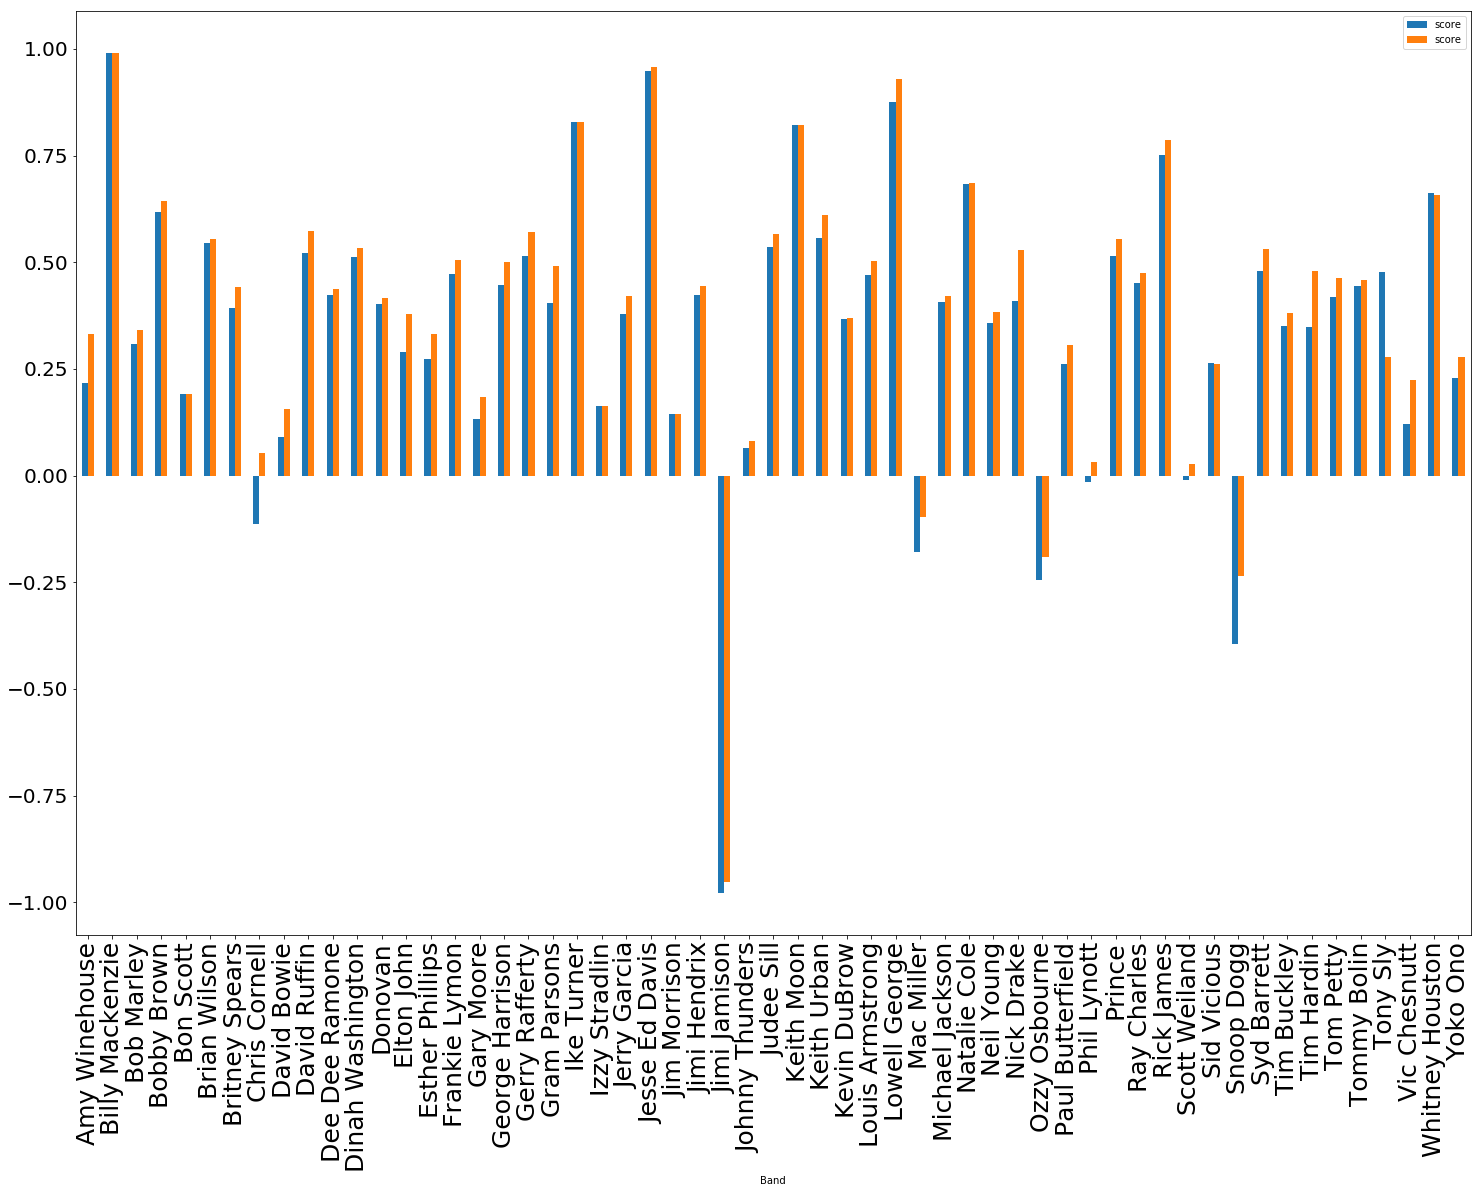

In [33]:
%matplotlib inline
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=20)
sentimentScores.plot.bar(figsize=(25,17))


We see that Jimi Jamison is an outlier with an extremely low score. We suspect the reason to be that he only has a few songs that contains a lot of negative words. To see how many songs he has:

In [27]:
len(finalLyrics[finalLyrics['Band'].str.contains('Jimi Jamison')])
finalLyrics[finalLyrics['Band'].str.contains('Jimi Jamison')]

,Band,Lyrics,Song,score,score
1834,Jimi Jamison,two worlds collide rival nations primitive cla...,Burning Hart,-0.9781,-0.9531


Here are the lyrics of his song Burning Hart, it does look like it has a lot of negative words. This confirm our suspicion and therefore more accurate analysis require that each artists have enough songs and lyrics. 

In [28]:
print(finalLyrics.loc[finalLyrics['Band'].str.contains('Jimi Jamison')].iloc[0]["Lyrics"])

two worlds collide rival nations primitive clash venting years frustrations bravely hope hope much stake seems freedoms ropes crowd understand east versus west man man nation stand alone burning heart burst theres quest answers unquenchable thirst darkest night rising spire burning heart unmistakable fire burning heart warrious code theres surrender though body says stop spirit cries never deep soul quiet ember know paradox drives us battle wills heat attack passion kills victory alone burning heart burst theres quest answers unquenchable thirst darkest night rising spire burning heart unmistakable fire burning heart burst theres quest answers unquenchable thirst darkest night rising spire burning heart unmistakable fire burning heart burst theres quest answers unquenchable thirst darkest night rising spire burning heart unmistakable fire burning heart


 Now we try to obtain the the word count for each artist. After the following code, a new dataframe df is created with columns "Band", "Lyrics", "word count", "number of words". Essentially, each row of the data frames contains an artist, ALL words in their songs, each word and their count, and the total number of words.

In [154]:
# concatenate all lyrics for each artist
def concat_(col):
    return "".join(col)

In [34]:
df = finalLyrics.loc[:,['Band','Lyrics']].groupby(['Band']).aggregate(concat_)

word_counts = []
num_words = []
for lyrics in df['Lyrics']:
    word_count =  pd.Series(lyrics.split()).value_counts()
    word_counts.append(word_count)
for lyrics in df['Lyrics']:
    num_words.append(len(lyrics))

    
df.insert(1, "word count", word_counts, True)
df.insert(2, "number of words",num_words, True )
df.head()

,Lyrics,word count,number of words
Band,,,
Amy Winehouse,ever darkness knew regret get accustomed right...,love 100 know 96 man ...,37993
Billy Mackenzie,love love say let fly away love wind wild wind...,living 13 lives 12 paradise...,1309
Bob Marley,whooooooo mr brown mr brown clown rides town c...,love 420 yeah 408 got ...,153425
Bobby Brown,ah ah ah things aint way used back day man mea...,girl 193 love 186 baby ...,37592
Bon Scott,aint necessarily aint necessarily tings dat yo...,sookie 24 hang 18 baby ...,1414


To get word counts for one artist:

In [36]:
df.loc["Mac Miller","word count"].head()

get     207
got     184
shit    183
aint    175
go      159
dtype: int64

Now for the independent/healthy set.

In [151]:
si2 = SentimentIntensityAnalyzer()
scores2 = [];
for song in finalLyrics2["Lyrics"]:
    results = si2.polarity_scores(song)
    scores = results["compound"]
    scores2.append(scores)
finalLyrics2.insert(3, "score",scores2, True)

In [152]:
sentimentScores2 = finalLyrics2.groupby(["Band"]).mean()
sentimentScores2.head()

,score
Band,
50 Cent,-0.468417
Adele,0.201954
Akon,-0.028909
Alicia Keys,0.437772
All-4-One,0.656489


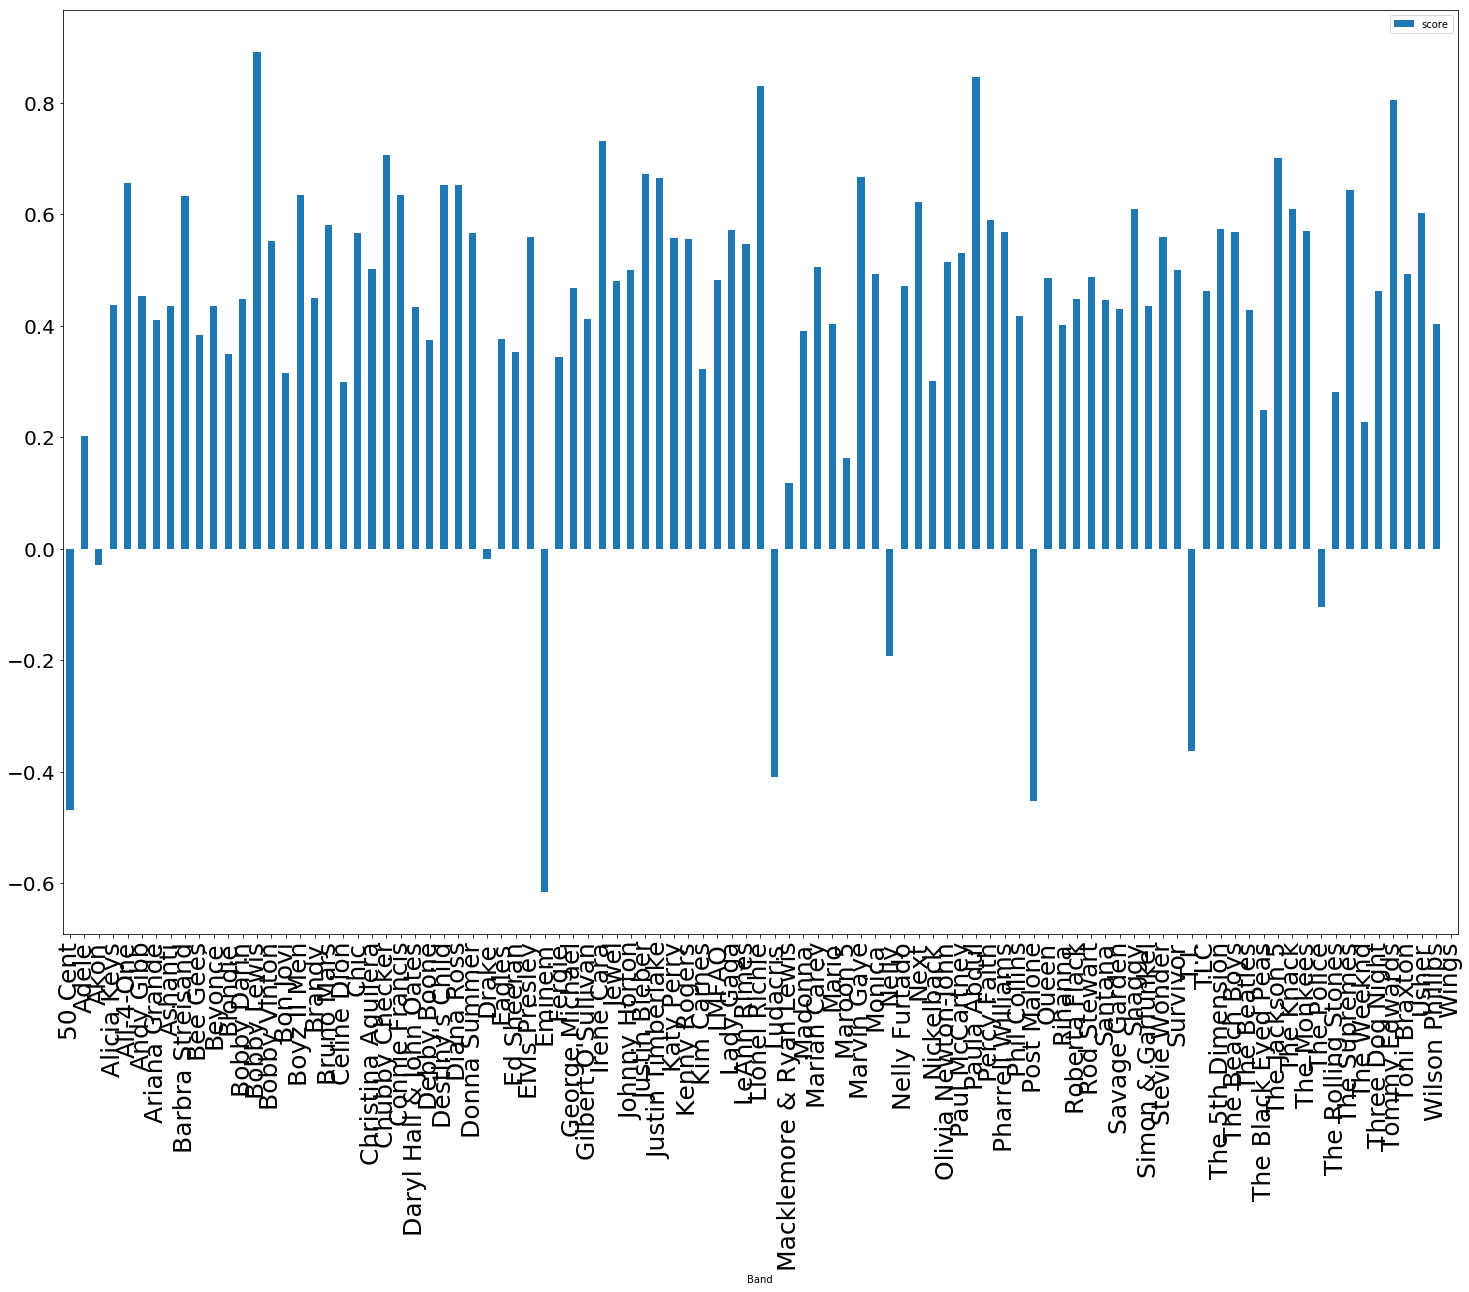

In [153]:
%matplotlib inline
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=20)
sentimentScores2.plot.bar(figsize=(25,17))


In [ ]:
df2 = finalLyrics2.loc[:,['Band','Lyrics']].groupby(['Band']).aggregate(concat_)

word_counts2 = []
num_words2 = []
for lyrics2 in df2['Lyrics']:
    word_count2 =  pd.Series(lyrics2.split()).value_counts()
    word_counts2.append(word_count)
for lyrics in df['Lyrics']:
    num_words.append(len(lyrics))

    
df.insert(1, "word count", word_counts, True)
df.insert(2, "number of words",num_words, True )
df.head()

## Data Visualization

## Privacy/Ethics Considerations

## Conclusion and Discussion